In [397]:
import numpy as np
from pylab import show, imshow, cm
%pylab inline
from scipy.stats import logistic
from numpy.random import normal
from numpy.random import uniform
from math import log
from scipy.special import logit
#logit(p) = log(p / (1 - p))
sigmoid = logistic.cdf
from scipy.special import expit
#expit(x) = 1 / (1 + e^(-x))
from scipy.stats import bernoulli
from math import ceil
import pickle
from random import sample
import itertools

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
# Getting back the objects:
with open('objs.pickle', 'rb') as f:  # Python 3: open(..., 'rb')
    W, b, c = pickle.load(f)

In [1]:
def h_probas(W, c, v):
    n, m = W.shape
    return expit([np.dot(W[i], v) + c[i] for i in range(n)])

def h_proba(W, c, v, i, m):
    return expit(np.dot(W[i], v) + c[i])

In [895]:
def train_RBM(m, n, data, iterations=1, k=1, W=None, b=None, c=None, learning_rate=0.1, batch_size=100):
    #initialization
    if (W is None):
        W = np.array([[uniform(-4*np.sqrt(6/(n+m)), 4*np.sqrt(6/(n+m))) for j in range(m)] for i in range(n)])
    if (b is None):
        #b = np.array([logit(np.mean([v[j] for v in data])) for j in range(m)])
        b = np.zeros(m)
    if (c is None):
        c = np.zeros(n)
    for iteration in range(iterations):
        #print progress
        if (iteration % 50 == 0):
            if (iteration > 0):
                print()
            print(iteration, end=' '*(len(str(iterations)) - len(str(iteration)) + 1))
    #train
        S = sample(data, batch_size)
        dW = np.zeros((n, m))
        db = np.zeros(m)
        dc = np.zeros(n)
        for v in S:
            v0 = np.array(v)
            vk = np.array(v)
            for t in range(k):
                hk = bernoulli.rvs(h_probas(W, c, vk))
                vk = bernoulli.rvs(expit([np.dot(W[:,j], hk) + b[j] for j in range(m)]))
            h0_probas = h_probas(W, c, v0)
            hk_probas = h_probas(W, c, vk)
            db += v0 - vk
            dc += h0_probas - hk_probas
            v0.resize(1, len(v0))
            h0_probas.resize((len(h0_probas), 1))
            hk_probas.resize((len(hk_probas), 1))
            vk.resize(1, len(vk))
            dW += np.matmul(h0_probas, v0) - np.matmul(hk_probas, vk)
        
        W += learning_rate * dW
        b += learning_rate * db
        c += learning_rate * dc
        iteration += 1
        print('#', end='')
    return W, b, c

In [754]:
import dataReader
images, labels = dataReader.loadMinst("Data/train-labels.idx1-ubyte", "Data/train-images.idx3-ubyte", binary = True, lowDimenson = True)
images = list(images.reshape(len(images), 196))
for i in range(len(images)):
    images[i] = np.append(images[i], [d == labels[i] for d in range(9)])

In [802]:
W, b, c = train_RBM(len(images[0]), 500, images, iterations=2000, W=W, b=b, c=c, k=1)

0   ##################################################
50  ##################################################
100 ##################################################
150 ##################################################

In [699]:
#initial_distribution = np.array([np.mean([v[j] for v in data]) for j in range(m)])

def generate(W, b, c, n, m, digit=-1, iterations=1):
    #v = sample(images, 1)[0]
    tail = [int(d==digit) for d in range(9)]
    v = [0.5 for j in range(m)]
    v[-9:] = tail
    for p in range(iterations):
        h = bernoulli.rvs(h_probas(W, c, v))
        v[0:-9] = bernoulli.rvs(expit([np.dot(W[:,j], h) + b[j] for j in range(m - 9)]))
    return v

In [773]:
def classify(W, b, c, image):
    n, m = W.shape
    tail = [0 for i in range(9)]
    h = bernoulli.rvs(h_probas(W, c, list(image) + tail))
    v = (expit([sum([W[i][j]*h[i] for i in range(n)]) + b[j] for j in range(-9, 0)]))
    return np.argmax(v)

In [899]:
W0 = np.array(W)
b0 = np.array(b)
c0 = np.array(c);

In [907]:
# Saving the objects:
with open('objs.pickle', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([W, b, c], f)

In [827]:
def test_RBM(W, b, c, data, test_size=5000):
    S = sample(images, test_size)
    right_answers = 0
    for v in S:
        right_answers += (classify(W, b, c, v[0:-9]) == np.argmax(v[-9:]))
    return right_answers / test_size

In [903]:
def train_with_tolerance(data, n, W=None, b=None, c=None, k=1, repeats=1, iterations=250, tolerance=0.01, learning_rate=0.1,
                        batch_size=100):
    initial_score = None
    for repeat in range(repeats):
        if (initial_score is None):
            initial_score = test_RBM(W, b, c, data)
        W0 = np.array(W)
        b0 = np.array(b)
        c0 = np.array(c)
        W, b, c = train_RBM(len(data[0]), n, data, iterations=iterations, W=W, b=b, c=c, k=k, learning_rate=learning_rate, 
                            batch_size=batch_size)
        updated_score = test_RBM(W, b, c, data)
        print(), print("Initial score: ", initial_score, ", updated score: ", updated_score)
        if (updated_score < initial_score + tolerance):
            W = W0
            b = b0
            c = c0
            print("Changes were rejected")
        else:
            initial_score = updated_score
            print("Changes were accepted")
    return W, b, c

In [902]:
W, b, c = train_with_tolerance(data=images, n=500, W=W, b=b, c=c, repeats=25, learning_rate=0.005, k=4, batch_size=60, 
                               tolerance=0.005, iterations=400)

0   ##################################################
50  ##################################################
100 ##################################################
150 ##################################################
200 ##################################################
250 ##################################################
300 ##################################################
350 ##################################################
Initial score:  0.5948 , updated score:  0.5902
Changes were rejected
0   ##################################################
50  ##################################################
100 ##################################################
150 ##################################################
200 ##################################################
250 ##################################################
300 ##################################################
350 ##################################################
Initial score:  0.5848 , updated score:  0.5922
Ch

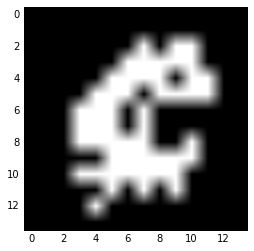

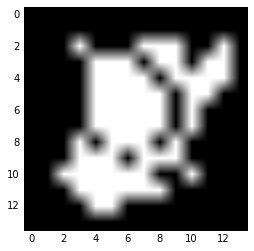

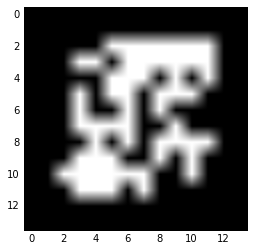

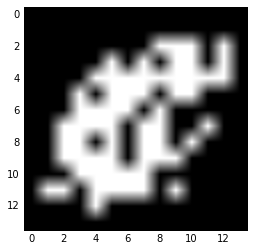

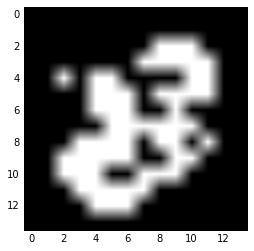

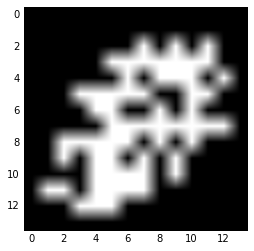

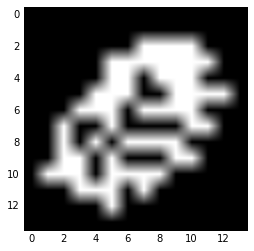

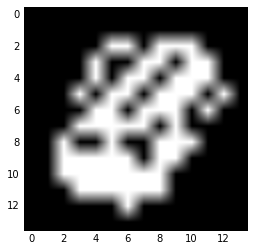

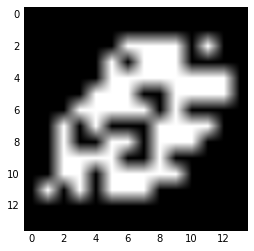

In [906]:
for digit in range(9):
    v = generate(W=W, b=b, c=c, n=500, m=len(images[0]), digit=digit, iterations=1)
    predicted_image = [[v[14*i + j] for j in range(14)] for i in range(14)]
    imshow(predicted_image, cmap=cm.gray)
    show()

In [875]:
zeroes = [images[i] for i in range(len(images)) if labels[i] == 0]
W_0, b_0, c_0 = train_RBM(len(zeroes[0]), 500, zeroes, iterations=100, W=W_0, b=b_0, c=c_0, k=1)

0   ##################################################
50  ##################################################

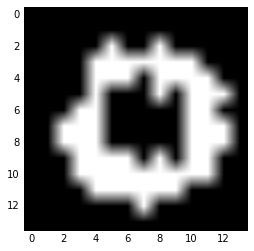

In [881]:
v = generate(W=W_0, b=b_0, c=c_0, n=500, m=len(images[0]), digit=0, iterations=1)
predicted_image = [[v[14*i + j] for j in range(14)] for i in range(14)]
imshow(predicted_image, cmap=cm.gray)
show()